The goal of this notebook is to do an initial exploration of the Russian 5-act comedies in verse.

In [1]:
import json
from os import listdir
from os import path
from os.path import isfile, join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from numpy.linalg import matrix_rank
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu

## I.  Data Preparation

### 1. Merge json files and metadata

In [121]:
all_files = [f for f in listdir('Play_Jsons') if f.count('.json')>0]

In [122]:
dfs = []
for file in all_files:
    with open('Play_Jsons/'+ file) as json_file:
        data = json.load(json_file)
        data['metadata']['speech_distribution'] = np.array(data['metadata']['speech_distribution'])
        df = pd.DataFrame(data['metadata'].values()).T
        df.columns = data['metadata'].keys()
        df['index'] = file.replace('.json','')
        dfs.append(df)

In [123]:
features_df = pd.concat(dfs, axis=0, sort=False)

In [5]:
metadata = pd.read_csv('Russian_Comedies.tsv', sep='\t')

In [6]:
all_data = metadata.merge(features_df, how='left', on='index')

In [7]:
all_data.to_csv('Comedies_Raw_Data.csv', index=False)

In [8]:
all_data.columns

Index(['index', 'title', 'first_name', 'last_name', 'creation_date',
       'translation', 'num_acts', 'free_iambs', 'url', 'original_file_format',
       'derived_format', 'additional_info', 'num_present_characters',
       'num_scenes_text', 'num_scenes_iarkho', 'speech_distribution',
       'percentage_monologues', 'percentage_duologues',
       'percentage_non_duologues', 'percentage_above_two_speakers',
       'av_percentage_non_speakers', 'sigma_iarkho', 'total_utterances',
       'num_verse_lines', 'rescaled_num_verse_lines', 'dialogue_vivacity',
       'num_scenes_with_split_verse_lines', 'num_scenes_with_split_rhymes',
       'percentage_scene_split_verse', 'percentage_scene_split_rhymes',
       'num_scenes_with_split_rhymes_verses', 'num_open_scenes',
       'percentage_open_scenes', 'percentage_scenes_rhymes_split_verse',
       'num_stage_directions', 'stage_directions_frequency',
       'num_word_tokens_in_stage_directions',
       'average_length_of_stage_direction',
   

In [9]:
all_data.sort_values(by='creation_date', inplace=True)

In [10]:
assert all_data.shape[0] == features_df.shape[0] == metadata.shape[0]

## II. Identify Only Five Act Comedies

In [11]:
five_acts = all_data[all_data['num_acts']==5].copy()

In [12]:
numeric_columns = [ 'num_present_characters',
                    'num_scenes_iarkho',
                    'num_scenes_text',
                    'percentage_monologues', 
                    'percentage_duologues',
                    'percentage_non_duologues', 
                    'percentage_above_two_speakers',
                    'av_percentage_non_speakers', 
                    'sigma_iarkho', 
                    'dialogue_vivacity',
                    'percentage_scene_split_verse', 
                    'percentage_scene_split_rhymes',
                    'percentage_open_scenes', 
                    'percentage_scenes_rhymes_split_verse',
                    'stage_directions_frequency',
                    'average_length_of_stage_direction',
                    'degree_of_verse_prose_interaction',
                    'percentage_scenes_with_discontinuous_change_characters'
                   ]

In [13]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(five_acts.loc[:, numeric_columns])

In [14]:
five_acts_scaled = five_acts.copy()
five_acts_scaled.loc[:, numeric_columns] = scaled

## III. Explore Iarkho's Original Four Features

### 1. Correlations Analysis

In [15]:
# remove translations from correlations analysis
not_translations_scaled = five_acts_scaled[five_acts_scaled.translation==0].copy()
not_translations = five_acts[five_acts.translation==0].copy()

In [16]:
original_four = ['num_present_characters','num_scenes_iarkho', 'sigma_iarkho', 'percentage_non_duologues']
not_translations_scaled.loc[:, original_four].corr()

,num_present_characters,num_scenes_iarkho,sigma_iarkho,percentage_non_duologues
num_present_characters,1.000000,0.560922,0.375990,0.380475
num_scenes_iarkho,0.560922,1.000000,-0.133850,0.116932
sigma_iarkho,0.375990,-0.133850,1.000000,0.522965
percentage_non_duologues,0.380475,0.116932,0.522965,1.000000


In [17]:
print('Matrix rank:', matrix_rank(not_translations_scaled.loc[:, original_four]))

Matrix rank: 4


In [18]:
alternative_four = ['num_present_characters','num_scenes_text']
not_translations_scaled.loc[:, alternative_four].corr()

,num_present_characters,num_scenes_text
num_present_characters,1.000000,0.345338
num_scenes_text,0.345338,1.000000


####  Conclusion:
It looks like the four original features are not strongly correlated, as was observed by Iarkho. The rank of the matrix is four, meaning that there are four linearly independent dimension, whereas Iarkho insisted on all four features being strongly positvely correlated and describing essentially one dimension. We analyzed the correlation between number of dramatic characters and number of scenes as they appear in the publication (i.e., not corresponding to the actual character entrances or exits). The correlation coefficient was lower: **0.35 vs. 0.55**.

This could be due to the fact that we are exploring a different genre, 5-act comedy, instead of 5-act tragedy. In this case, this would limit universality of Iarkho's proposed features across other genres. Alternatively, there could be an error in Iarkho's calculations or a bias in his approach. Reguardless of the reasons, unlike Iarkho, we will not be able to take the mean of the four features and describe it as the "evolution curve of the style", since each feature describes a separate dimension.

### 2. Distribution Normality

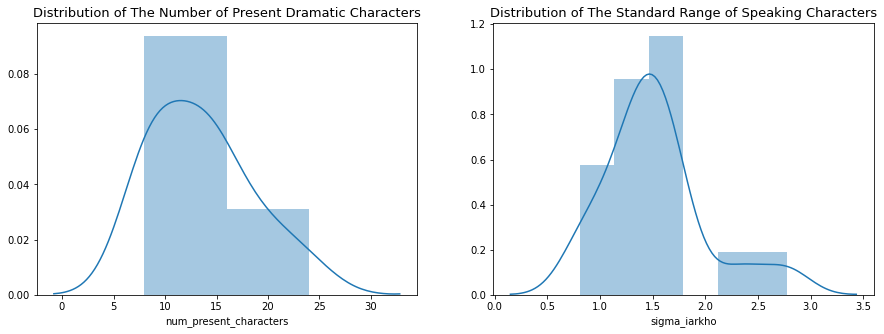

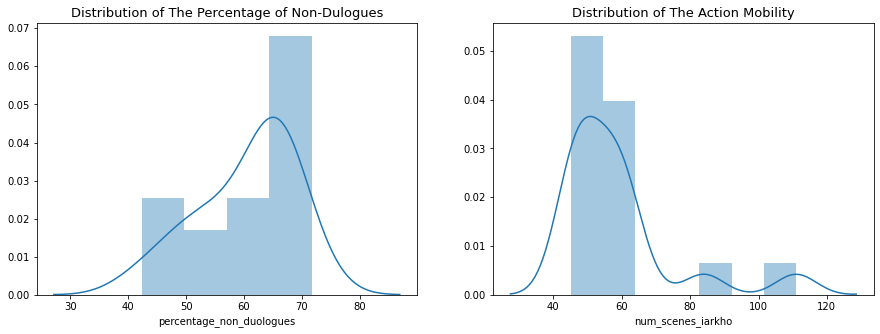

In [19]:
plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.title('Distribution of The Number of Present Dramatic Characters', fontsize=13)
sns.distplot(not_translations.loc[:,'num_present_characters'])

plt.subplot(122)
plt.title('Distribution of The Standard Range of Speaking Characters', fontsize=13)
sns.distplot(not_translations.loc[:,'sigma_iarkho'])

plt.show()

plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.title('Distribution of The Percentage of Non-Dulogues', fontsize=13)
sns.distplot(not_translations.loc[:,'percentage_non_duologues'])

plt.subplot(122)
plt.title('Distribution of The Action Mobility', fontsize=13)
sns.distplot(not_translations.loc[:,'num_scenes_iarkho'])

plt.show()

In [20]:
for column in not_translations.loc[:, original_four].columns:
    print(column)
    print('\tProbability of normal distribution:',
          round(shapiro(not_translations.loc[:, column])[1], 5))

num_present_characters
	Probability of normal distribution: 0.10454
num_scenes_iarkho
	Probability of normal distribution: 0.00031
sigma_iarkho
	Probability of normal distribution: 0.10414
percentage_non_duologues
	Probability of normal distribution: 0.08401


In [94]:
not_translations.columns

Index(['index', 'title', 'first_name', 'last_name', 'creation_date',
       'translation', 'num_acts', 'free_iambs', 'url', 'original_file_format',
       'derived_format', 'additional_info', 'num_present_characters',
       'num_scenes_text', 'num_scenes_iarkho', 'speech_distribution',
       'percentage_monologues', 'percentage_duologues',
       'percentage_non_duologues', 'percentage_above_two_speakers',
       'av_percentage_non_speakers', 'sigma_iarkho', 'total_utterances',
       'num_verse_lines', 'rescaled_num_verse_lines', 'dialogue_vivacity',
       'num_scenes_with_split_verse_lines', 'num_scenes_with_split_rhymes',
       'percentage_scene_split_verse', 'percentage_scene_split_rhymes',
       'num_scenes_with_split_rhymes_verses', 'num_open_scenes',
       'percentage_open_scenes', 'percentage_scenes_rhymes_split_verse',
       'num_stage_directions', 'stage_directions_frequency',
       'num_word_tokens_in_stage_directions',
       'average_length_of_stage_direction',
   

### Normaility:
The hypothesis about normal distribution can be rejected only for one feature - number of scenes (i.e., action mobility). For other features the p-value is above the standard significance level of .05. Therefore, we cannot reject normality for other three features.

### 3. Feature means and standard deviations

#### Means

In [21]:
not_translations.loc[:, original_four].max()

num_present_characters       24.000
num_scenes_iarkho           111.000
sigma_iarkho                  2.771
percentage_non_duologues     71.740
dtype: float64

In [22]:
not_translations.loc[:, original_four].mean()

num_present_characters      13.50000
num_scenes_iarkho           58.43750
sigma_iarkho                 1.51750
percentage_non_duologues    60.37625
dtype: float64

#### Standard Deviations

In [23]:
not_translations.loc[:, original_four].std()

num_present_characters       4.871687
num_scenes_iarkho           17.138529
sigma_iarkho                 0.494002
percentage_non_duologues     8.295416
dtype: float64

In [24]:
def identify_outliers(df, column):
    # upper boundary
    upper_boundary = df[column].mean() + (2 *df[column].std())
    lower_boundary = df[column].mean() - (2 *df[column].std())
    
    high_outlier = df[df[column] > upper_boundary]
    low_outlier = df[df[column] < lower_boundary]
    
    return high_outlier, low_outlier

In [25]:
# upper boundary
not_translations['sigma_iarkho'].mean() + (2 *not_translations['sigma_iarkho'].std())

2.5055043184790913

### 4. Unusually High Standard Range of the Speaking Characters

Two comedies have high standard range of the number of speaking characters (sigma). The mean standard range of the speaking characters is 1.49, standard deviation is 0.49. From them, *Iabeda* can be considered an outlier as it is over two standard deviations away from the mean.

In [26]:
not_translations[not_translations['sigma_iarkho'] > 2][['title', 
                                                        'last_name', 
                                                        'first_name', 
                                                        'creation_date',
                                                        'sigma_iarkho']]

,title,last_name,first_name,creation_date,sigma_iarkho
5,Iabeda,Vasilii,Kapnist,1794,2.771
8,V sem''e ne bez uroda,Unknown,Unknown,1813,2.323


In [27]:
high, low = identify_outliers(not_translations, 'sigma_iarkho')

In [28]:
high[['title', 
    'last_name', 
    'first_name', 
    'creation_date',
    'sigma_iarkho']]

,title,last_name,first_name,creation_date,sigma_iarkho
5,Iabeda,Vasilii,Kapnist,1794,2.771


In [29]:
len(low)

0

In [30]:
speech_distribution_one = np.array(not_translations[not_translations['index']=='R_6']['speech_distribution'])[0]
speech_distribution_iabeda = pd.DataFrame(pd.DataFrame(speech_distribution_one).T.iloc[1,:])
speech_distribution_iabeda.columns = ['scenes']
speech_distribution_iabeda['speakers'] = pd.DataFrame(speech_distribution_one).T.iloc[0,:].tolist()

In [31]:
speech_distribution_two = np.array(not_translations[not_translations['index']=='R_9']['speech_distribution'])[0]
speech_distribution_semie = pd.DataFrame(pd.DataFrame(speech_distribution_two).T.iloc[1,:])
speech_distribution_semie.columns = ['scenes']
speech_distribution_semie['speakers'] = pd.DataFrame(speech_distribution_two).T.iloc[0,:].tolist()

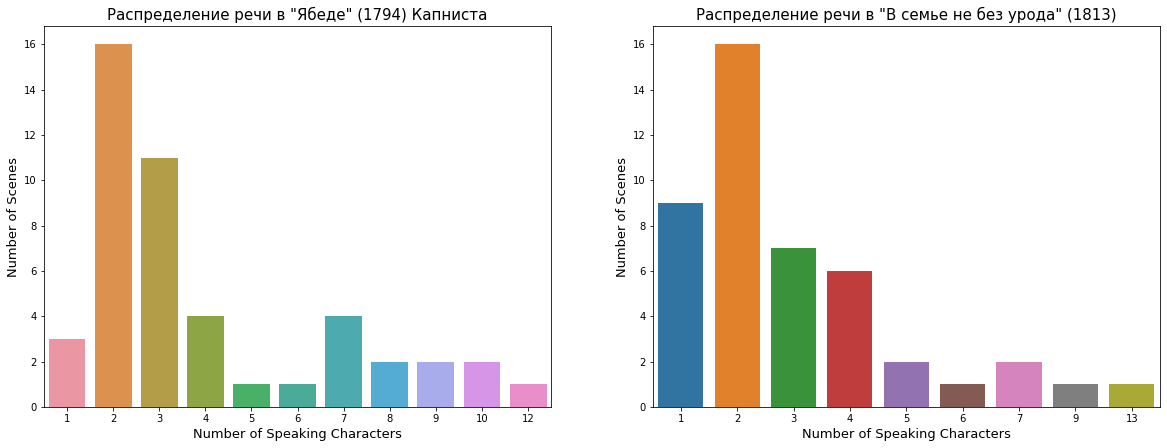

In [32]:
plt.figure(figsize=(20, 7))
plt.subplot(121)
plt.title('Распределение речи в "Ябеде" (1794) Капниста', fontsize=15)
sns.barplot(x='speakers', y='scenes', data=speech_distribution_iabeda)
plt.xlabel('Number of Speaking Characters', fontsize=13)
plt.ylabel('Number of Scenes', fontsize=13)

plt.subplot(122)
plt.title('Распределение речи в "В семье не без урода" (1813)', fontsize=15)
sns.barplot(x='speakers', y='scenes', data=speech_distribution_semie)
plt.xlabel('Number of Speaking Characters', fontsize=13)
plt.ylabel('Number of Scenes', fontsize=13)

plt.show()

### 5. Unusually High Action Mobility

These two comedieshave extremely high action mobility. The mean action mobility is 58.31 and standard deviation is 17.93. However, only one of them, *Zhiteiiskaia shkola*, can be considered an outlier (i.e., it is **more than 2 standard deviations** away from the mean)

In [33]:
not_translations[not_translations['num_scenes_iarkho']>80][['title', 
                                                            'last_name', 
                                                            'first_name', 
                                                            'creation_date',
                                                            'num_scenes_iarkho']]

,title,last_name,first_name,creation_date,num_scenes_iarkho
11,Chudnyia vstrechi,Boris,Fedorov,1818,84
25,Zhiteiiskaia shkola,Piotr,Grigor’ev,1849,111


In [34]:
high, low = identify_outliers(not_translations, 'num_scenes_iarkho')

In [35]:
high

,index,title,first_name,last_name,creation_date,translation,num_acts,free_iambs,url,original_file_format,...,percentage_open_scenes,percentage_scenes_rhymes_split_verse,num_stage_directions,stage_directions_frequency,num_word_tokens_in_stage_directions,average_length_of_stage_direction,num_verse_splitting_stage_directions,degree_of_verse_prose_interaction,number_scenes_with_discontinuous_change_characters,percentage_scenes_with_discontinuous_change_characters
25,R_26,Zhiteiiskaia shkola,Grigor’ev,Piotr,1849,0,5,1,NaN,pdf,...,58.559,13.514,1035,29.571,3502,3.384,401,11.457,2,1.802


In [36]:
len(low)

0

### 6. Potential Outliers for Other Features
#### Number of Dramatic Characters 

In [37]:
high, low = identify_outliers(not_translations, 'num_present_characters')

In [38]:
high[['title', 
    'last_name', 
    'first_name', 
    'creation_date',
    'num_present_characters']]

,title,last_name,first_name,creation_date,num_present_characters
11,Chudnyia vstrechi,Boris,Fedorov,1818,24


In [39]:
len(low)

0

#### Percentage of Non-Duologues

In [40]:
high, low = identify_outliers(not_translations, 'percentage_non_duologues')

In [41]:
len(high)

0

In [42]:
len(low)

1

In [43]:
low[['title', 
    'last_name', 
    'first_name', 
    'creation_date',
    'percentage_non_duologues']]

,title,last_name,first_name,creation_date,percentage_non_duologues
23,Novaia shkola muzhei,Rafail,Zotov,1842,42.31


## II. Evolution of the Four Features and Hypothesis Testing 

Our hypothesis was based on our original exploration of Sperantov's periodization of tragedies. We found out that there was a significant difference between 5-act tragedies **before 1794** and **after 1794** based on all Sperantov's features. We wanted to check if the same boundary applies to 5-act comedy in verse.

- **Our null hypothesis**: no difference between 5-act comedies in verse before 1794 and after 1794.
- **Alternative hypothesis**: there is a signficant difference between comedies before 1794 nd after 1794.

- **Significance level**: 0.05

### 1. Number of Dramatic Characters

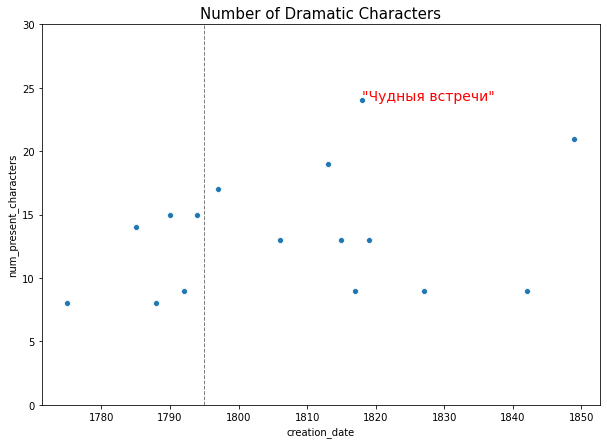

In [44]:
plt.figure(figsize=(10, 7))
plt.title('Number of Dramatic Characters', fontsize=15)
sns.scatterplot(x='creation_date', y='num_present_characters', data=not_translations)
period_one = plt.axvline(1795, color='grey',linestyle='dashed', linewidth=1)
plt.yticks(np.arange(0, max(five_acts['num_present_characters'])+10, 5))
plt.text(1818, 24, '"Чудныя встречи"', horizontalalignment='left', color='red', fontsize=14)
plt.show()

In [45]:
period_one = not_translations[not_translations['creation_date']<=1794]
period_two = not_translations[not_translations['creation_date']>1794]

In [46]:
period_two_without_outlier = period_two[period_two['title']!='Chudnyia vstrechi'].copy()

In [47]:
period_one['num_present_characters'].mean()

11.5

In [48]:
period_one['num_present_characters'].std()

3.5071355833500366

In [49]:
period_two_without_outlier['num_present_characters'].mean()

13.666666666666666

In [50]:
period_two_without_outlier['num_present_characters'].std()

4.47213595499958

In [51]:
print(mannwhitneyu(period_one['num_present_characters'], 
                   period_two_without_outlier['num_present_characters']))

MannwhitneyuResult(statistic=19.5, pvalue=0.20129579790379404)


In [77]:
from scipy.stats import ttest_ind
print(ttest_ind(period_one['num_present_characters'], 
                   period_two['num_present_characters']))

Ttest_indResult(statistic=-1.3010362078381188, pvalue=0.21425233218170373)


### 2. Standard Range of the Speaking Characters

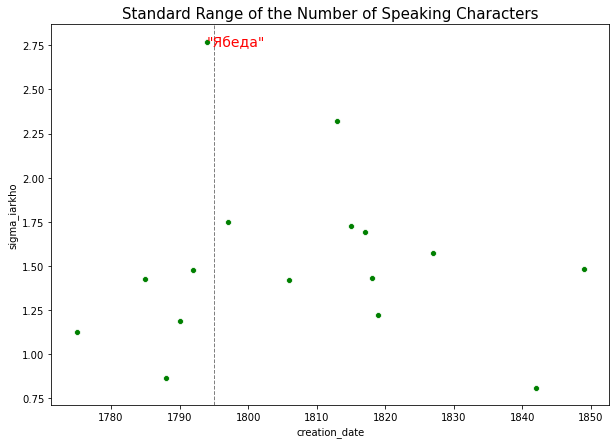

In [52]:
plt.figure(figsize=(10, 7))
plt.title('Standard Range of the Number of Speaking Characters', fontsize=15)
sns.scatterplot(x='creation_date', y='sigma_iarkho', data=not_translations, color='green')
period = plt.axvline(1795, color='grey',linestyle='dashed', linewidth=1)
plt.text(1794, 2.745, '"Ябеда"', horizontalalignment='left', color='red', fontsize=14)
plt.show()

### 3. Character Mobility

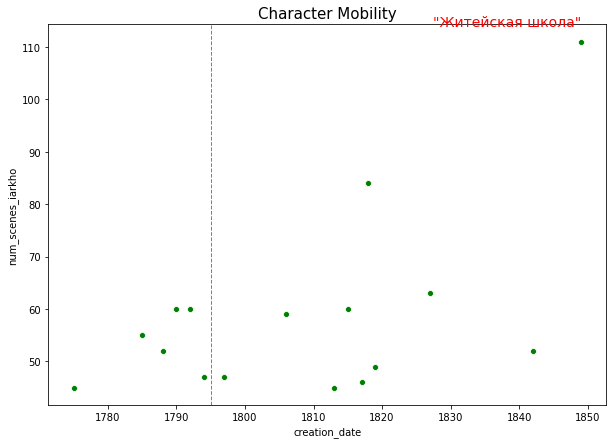

In [53]:
plt.figure(figsize=(10, 7))
plt.title('Character Mobility', fontsize=15)
sns.scatterplot(x='creation_date', y='num_scenes_iarkho', data=not_translations, color='green')
period = plt.axvline(1795, color='grey',linestyle='dashed', linewidth=1)
plt.text(1849, 114, '"Житейская школа"', horizontalalignment='right', color='red', fontsize=14)
plt.show()

In [54]:
period_one['num_scenes_iarkho'].mean()

53.166666666666664

In [55]:
period_one['num_scenes_iarkho'].std()

6.369196704975177

In [56]:
period_two_without_outlier['num_scenes_iarkho'].mean()

59.111111111111114

In [57]:
period_two_without_outlier['num_scenes_iarkho'].std()

20.551426011620485

In [58]:
period_two_without_outlier = period_two[period_two['title']!='Zhiteiiskaia shkola'].copy()

In [59]:
print(mannwhitneyu(period_one['num_scenes_iarkho'], 
                   period_two_without_outlier['num_scenes_iarkho']))

MannwhitneyuResult(statistic=25.5, pvalue=0.4527982410364023)


### 4. Percentage of Non-Duologues

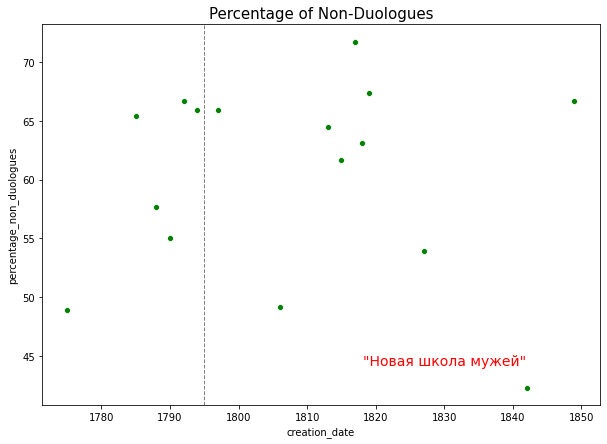

In [60]:
plt.figure(figsize=(10, 7))
plt.title('Percentage of Non-Duologues', fontsize=15)
sns.scatterplot(x='creation_date', y='percentage_non_duologues', data=not_translations, color='green')
plt.text(1842, 44.23, '"Новая школа мужей"', horizontalalignment='right', color='red', fontsize=14)
period = plt.axvline(1795, color='grey',linestyle='dashed', linewidth=1)
plt.show()

In [61]:
period_one['percentage_non_duologues'].mean()

59.94333333333333

In [62]:
period_one['percentage_non_duologues'].std()

7.258952174154798

In [63]:
period_two_without_outlier = period_two[period_two['title'] != 'Novaia shkola muzhei']

In [64]:
period_two_without_outlier['percentage_non_duologues'].mean()

62.67222222222222

In [65]:
period_two_without_outlier['percentage_non_duologues'].std()

7.0159599802482076

In [66]:
print(mannwhitneyu(period_one['percentage_non_duologues'], 
                   period_two_without_outlier['percentage_non_duologues']))

MannwhitneyuResult(statistic=21.0, pvalue=0.2580587392121873)


### 4. 

NameError: name 'summary' is not defined

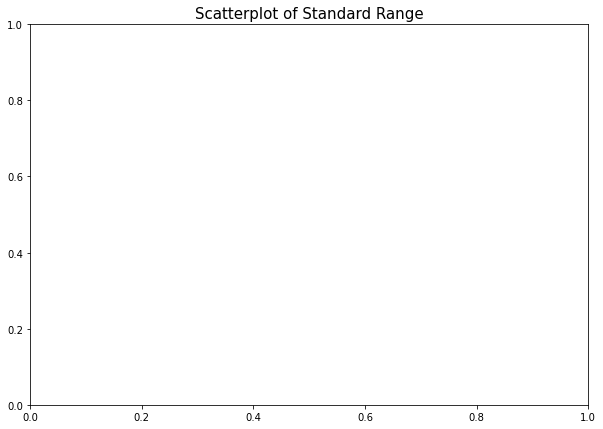

In [67]:
plt.figure(figsize=(10, 7))
plt.title('Scatterplot of Standard Range', fontsize=15)
sns.scatterplot(x='creation_year', y='sigma', data=summary)
plt.show()

In [ ]:
upper_boundary = period_one['percentage_scenes_with_discontinuous_change_characters'].mean() + 2*period_one['percentage_scenes_with_discontinuous_change_characters'].std()
lower_boundary = period_one['percentage_scenes_with_discontinuous_change_characters'].mean() - 2*period_one['percentage_scenes_with_discontinuous_change_characters'].std()

In [ ]:
display(period_one[period_one['percentage_scenes_with_discontinuous_change_characters']>=upper_boundary])
display(period_one[period_one['percentage_scenes_with_discontinuous_change_characters']<=lower_boundary])

In [ ]:
period_one.describe()

In [ ]:
period_two.describe()

In [ ]:
period_one.corr()

In [ ]:
period_two.corr()

In [ ]:
plt.figure(figsize=(10, 7))
plt.title('Scatterplot of Dialogue Vivacity', fontsize=15)
sns.scatterplot(x='creation_year', y='dialogue_vivacity', data=summary)
plt.show()

In [70]:
period_one.columns

Index(['index', 'title', 'first_name', 'last_name', 'creation_date',
       'translation', 'num_acts', 'free_iambs', 'url', 'original_file_format',
       'derived_format', 'additional_info', 'num_present_characters',
       'num_scenes_text', 'num_scenes_iarkho', 'speech_distribution',
       'percentage_monologues', 'percentage_duologues',
       'percentage_non_duologues', 'percentage_above_two_speakers',
       'av_percentage_non_speakers', 'sigma_iarkho', 'total_utterances',
       'num_verse_lines', 'rescaled_num_verse_lines', 'dialogue_vivacity',
       'num_scenes_with_split_verse_lines', 'num_scenes_with_split_rhymes',
       'percentage_scene_split_verse', 'percentage_scene_split_rhymes',
       'num_scenes_with_split_rhymes_verses', 'num_open_scenes',
       'percentage_open_scenes', 'percentage_scenes_rhymes_split_verse',
       'num_stage_directions', 'stage_directions_frequency',
       'num_word_tokens_in_stage_directions',
       'average_length_of_stage_direction',
   

In [71]:
from scipy.stats import mannwhitneyu

print(mannwhitneyu(period_one['num_present_characters'], 
                   period_two['num_present_characters']))

MannwhitneyuResult(statistic=19.5, pvalue=0.13618029166298845)


In [ ]:
print(mannwhitneyu(period_one['number_scenes'], 
                   period_two['number_scenes']))

In [ ]:
print(mannwhitneyu(period_one['sigma'], 
                   period_two['sigma']))

In [ ]:
print(mannwhitneyu(period_one['non_duologues'], 
                   period_two['non_duologues']))

In [ ]:
print(mannwhitneyu(period_one['non_duologues'], 
                   period_two['non_duologues']))

In [ ]:
['number_characters', 'number_scenes', 'non_duologues', 'sigma',
                  'dialogue_vivacity', 'percentage_open_scenes', 'stage_directions_frequency',
                  'average_length_of_stage_direction', 'degree_of_verse_prose_interaction',
                  'percentage_scenes_with_discontinuous_change_characters']

In [ ]:
from scipy.stats import ttest_ind

print(ttest_ind(period_one['dialogue_vivacity'], 
                   period_two['dialogue_vivacity']))

In [ ]:
plt.figure(figsize=(10, 7))
plt.title('Scatterplot of Stage Directions Frequency', fontsize=15)
sns.scatterplot(x='creation_year', y='stage_directions_frequency', data=summary)
plt.show()

In [ ]:
plt.figure(figsize=(10, 7))
plt.title('Scatterplot of Average Length of Stage Direction', fontsize=15)
sns.scatterplot(x='creation_year', y='average_length_of_stage_direction', data=summary)
plt.show()

In [ ]:
print(ttest_ind(period_one['average_length_of_stage_direction'], 
                   period_two['average_length_of_stage_direction']))

In [ ]:
plt.figure(figsize=(10, 7))
plt.title('Scatterplot of Prose Verse Interaction', fontsize=15)
sns.scatterplot(x='creation_year', y='degree_of_verse_prose_interaction', data=summary)
plt.show()

In [ ]:
print(ttest_ind(period_one['degree_of_verse_prose_interaction'], 
                   period_two['degree_of_verse_prose_interaction']))

In [ ]:
print(mannwhitneyu(period_one['percentage_scenes_with_discontinuous_change_characters'], 
                   period_two['percentage_scenes_with_discontinuous_change_characters']))

In [ ]:
plt.figure(figsize=(10, 7))
plt.title('Scatterplot of Scenes with Discontinuos Character Change', fontsize=15)
sns.scatterplot(x='creation_year', y='percentage_scenes_with_discontinuous_change_characters', data=summary)
plt.show()

In [ ]:
nedovolnye_speech = [
      [
        1,
        10
      ],
      [
        2,
        20
      ],
      [
        3,
        12
      ],
      [
        4,
        10
      ],
      [
        5,
        5
      ],
      [
        6,
        1
      ]
    ]

In [ ]:
speech_distribution = pd.DataFrame(nedovolnye_speech).T.iloc[1,:]
speech_distribution.columns = pd.DataFrame(nedovolnye_speech).T.iloc[0,:].tolist()

In [ ]:
gore_speech = [
      [
        1,
        21
      ],
      [
        2,
        31
      ],
      [
        3,
        12
      ],
      [
        4,
        6
      ],
      [
        8,
        1
      ],
      [
        9,
        1
      ],
      [
        10,
        1
      ],
      [
        18,
        1
      ]
    ]

In [ ]:
gore_speech_distribution = pd.DataFrame(gore_speech).T.iloc[1,:]
gore_speech_distribution.columns = pd.DataFrame(gore_speech).T.iloc[0,:].tolist()

In [ ]:
blag_teatr= [
      [
        1,
        16
      ],
      [
        2,
        19
      ],
      [
        3,
        12
      ],
      [
        4,
        10
      ],
      [
        5,
        4
      ],
      [
        6,
        3
      ],
      [
        7,
        2
      ]
    ]

In [ ]:
teatr_speech_distribution = pd.DataFrame(blag_teatr).T.iloc[1,:]
teatr_speech_distribution.columns = pd.DataFrame(blag_teatr).T.iloc[0,:].tolist()

In [ ]:
sovr_zhizn_speech = [
      [
        1,
        17
      ],
      [
        2,
        27
      ],
      [
        3,
        7
      ],
      [
        4,
        1
      ]
    ]

In [ ]:
zhizn_speech_distribution = pd.DataFrame(sovr_zhizn_speech).T.iloc[1,:]
zhizn_speech_distribution.columns = pd.DataFrame(sovr_zhizn_speech).T.iloc[0,:].tolist()

In [ ]:
vospitanie = [
      [
        1,
        9
      ],
      [
        2,
        12
      ],
      [
        3,
        7
      ],
      [
        4,
        5
      ],
      [
        5,
        1
      ],
      [
        6,
        1
      ],
      [
        7,
        2
      ]
    ]

In [ ]:
vospitanie_speech_distribution = pd.DataFrame(vospitanie).T.iloc[1,:]
vospitanie_speech_distribution.columns = pd.DataFrame(vospitanie).T.iloc[0,:].tolist()

In [ ]:
plt.title('Воспитание, или вот приданое')
sns.barplot(x=vospitanie_speech_distribution.columns, y=vospitanie_speech_distribution)
plt.show()

In [ ]:
plt.title('Горе от ума')
sns.barplot(x=gore_speech_distribution.columns, y=gore_speech_distribution)
plt.show()

In [ ]:
plt.title('Благородный театр')
sns.barplot(x=teatr_speech_distribution.columns, y=teatr_speech_distribution)
plt.show()

In [ ]:
plt.title("Недовольные")
sns.barplot(x=speech_distribution.columns, y=speech_distribution)
plt.show()

In [ ]:
plt.title('Комедия из современной жизни')
sns.barplot(x=zhizn_speech_distribution.columns, y=zhizn_speech_distribution)
plt.show()